In [38]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import Input
import numpy as np
import pandas as pd
import os
import keras
from keras.layers import Conv2D, MaxPool2D, add,Dropout,Dense,Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, Callback
import sklearn
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import librosa

In [25]:
warnings.filterwarnings("ignore")
sns.set()
mini_batch_size=256

In [26]:
X_Train = np.load('DataSet_P/Train/X_final_CQT_.npy', mmap_mode = 'r')
X_Train.shape

(28721, 38, 1, 252)

In [27]:
Y_Train = np.load('DataSet_P/Train/Y_final_Label_.npy', mmap_mode = 'r')
Y_Train.shape

(28721, 38, 1, 88)

In [28]:
X_Test = np.load('DataSet_P/Test/X_final_CQT_.npy', mmap_mode = 'r')
X_Test.shape

(15219, 38, 1, 252)

In [29]:
Y_Test = np.load('DataSet_P/Test/Y_final_Label_.npy', mmap_mode = 'r')
Y_Test.shape

(15219, 38, 1, 88)

In [30]:
# The X_train is converted to 4 dimension with a mini_batch size of 256 / 400

X_Train = X_Train[:int(X_Train.shape[0] / mini_batch_size) * mini_batch_size,:]
X_Train.shape

(28672, 38, 1, 252)

In [31]:
# The Y_train is converted to 4 dimension with a mini_batch size of 256 / 400 similar to X_train

Y_Train = Y_Train[:int(Y_Train.shape[0] / mini_batch_size) * mini_batch_size,:]
Y_Train.shape

(28672, 38, 1, 88)

In [32]:
X_Train = tf.transpose(X_Train, perm=[0, 1, 3, 2])
X_Train.shape

TensorShape([28672, 38, 252, 1])

In [33]:
X_Test = tf.transpose(X_Test, perm=[0, 1, 3, 2])
X_Test.shape

TensorShape([15219, 38, 252, 1])

In [46]:
minibatch= True

In [47]:
# training the data in tensorflow with mini batch size equal to 400

Train_data = tf.data.Dataset.from_tensor_slices((X_Train, Y_Train))
Train_data = Train_data.batch(mini_batch_size)

Test_data = tf.data.Dataset.from_tensor_slices((X_Test ,Y_Test))
Test_data = Test_data.batch(mini_batch_size)

In [48]:
Train_data

<BatchDataset shapes: ((None, 38, 252, 1), (None, 38, 1, 88)), types: (tf.float64, tf.float64)>

In [49]:
Test_data

<BatchDataset shapes: ((None, 38, 252, 1), (None, 38, 1, 88)), types: (tf.float64, tf.float64)>

In [50]:
# Parameters for the layers of neural network 

window_size = 7
min_midi = librosa.note_to_midi('A0')
max_midi = librosa.note_to_midi('C8')
note_range = max_midi - min_midi + 1

In [59]:
input_shape = (38, 252, 1)
model = tf.keras.Sequential()

#stage1
model.add(Conv2D(filters=50, kernel_size=(5,25), activation='elu', input_shape=input_shape, padding="same", strides=1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(1, 3), strides=(1, 3), padding="same"))

#stage2
model.add(Conv2D(filters=50, kernel_size=(3,5), strides=1, activation='elu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(1, 3), strides=(1, 3), padding="same"))

#stage3
model.add(Conv2D(filters=1000, kernel_size=(1,28), activation='elu'))
model.add(Dropout(rate=0.5))

#stage4
model.add(Conv2D(filters=500, kernel_size=1, activation='elu', padding="same"))
model.add(Dropout(rate=0.5))

#stage5
model.add(Conv2D(filters=88, kernel_size=1, activation='sigmoid'))

In [60]:
# Code for the Accuracy of the Model 

class AccuracyHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

In [61]:
# Calculating the accuracy of the model using adam as optimizer and the learning rate is 0.001

optimizer1 = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer= optimizer1, metrics=['accuracy'])
history = AccuracyHistory()

# checkpoint = ModelCheckpoint(model_ckpt,monitor='val_loss',verbose=1,save_best_only=True,mode='min')
early_stop = EarlyStopping(patience=5, monitor='val_loss',verbose=1, mode='min')
callbacks = [history,early_stop]

In [62]:
history = model.fit(Train_data, epochs=12, batch_size=mini_batch_size, validation_data=Test_data, verbose = 1, callbacks=callbacks)

Epoch 1/12
112/112 [==============================] - 655s 6s/step - loss: 0.2144 - accuracy: 0.0576 - val_loss: 0.1609 - val_accuracy: 0.0860
Epoch 2/12
112/112 [==============================] - 685s 6s/step - loss: 0.1454 - accuracy: 0.1978 - val_loss: 0.1203 - val_accuracy: 0.2365
Epoch 3/12
112/112 [==============================] - 709s 6s/step - loss: 0.1148 - accuracy: 0.2852 - val_loss: 0.1111 - val_accuracy: 0.2993
Epoch 4/12
112/112 [==============================] - 733s 7s/step - loss: 0.1031 - accuracy: 0.3099 - val_loss: 0.1165 - val_accuracy: 0.3328
Epoch 5/12
112/112 [==============================] - 765s 7s/step - loss: 0.0952 - accuracy: 0.3250 - val_loss: 0.0968 - val_accuracy: 0.3083
Epoch 6/12
112/112 [==============================] - 735s 7s/step - loss: 0.0885 - accuracy: 0.3412 - val_loss: 0.0970 - val_accuracy: 0.3060
Epoch 7/12
112/112 [==============================] - 691s 6s/step - loss: 0.0838 - accuracy: 0.3486 - val_loss: 0.0964 - val_accuracy: 0.3270

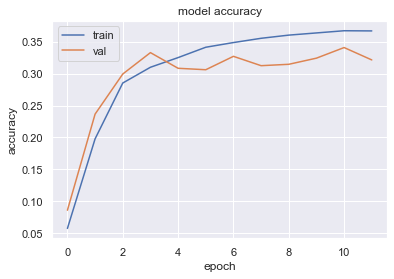

In [63]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

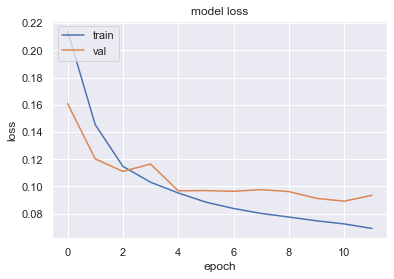

In [64]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [65]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 38, 252, 50)       6300      
                                                                 
 batch_normalization_15 (Bat  (None, 38, 252, 50)      200       
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 38, 84, 50)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 38, 84, 50)        37550     
                                                                 
 batch_normalization_16 (Bat  (None, 38, 84, 50)       200       
 chNormalization)                                                
                                                     

In [66]:
from sklearn.metrics import precision_recall_fscore_support

In [67]:
def opt_thresholds(y_true,y_scores):
    othresholds = np.zeros(y_scores.shape[1])
    print(othresholds.shape)
    for label, (label_scores, true_bin) in enumerate(zip(y_scores.T,y_true.T)):
        precision, recall, thresholds = sklearn.metrics.precision_recall_curve(true_bin, label_scores)
        max_f1 = 0
        max_f1_threshold = .5
        for r, p, t in zip(recall, precision, thresholds):
            if p + r == 0: continue
            if (2*p*r)/(p + r) > max_f1:
                max_f1 = (2*p*r)/(p + r)
                max_f1_threshold = t
        # print("label %f: max_f1_threshold %f => max_f1 %f" %(label, max_f1_threshold, max_f1))
        othresholds[label] = max_f1_threshold
    return othresholds

In [68]:
tf.config.run_functions_eagerly(True)

In [106]:
#calculating threshold on validation data
x = X_Test
y_true = Y_Test
y_scores = model.predict(x)

In [108]:
y_scores = np.reshape(y_scores, (578322, 88))
Y_Test = np.reshape(Y_Test, (578322, 88))

In [109]:
othresholds = opt_thresholds(y_true, y_scores)

(88,)


In [110]:
#evaludate this over validation data
y_pred = y_scores > othresholds

In [111]:
#precision, recall, fbetascore, support =>p, r, f, s
p,r,f,s = sklearn.metrics.precision_recall_fscore_support(y_true,y_pred,average='micro')
print("%f %f %f" %(p, r, f))

0.597665 0.681797 0.636965


In [112]:
np.save('y_pred.npy', y_pred)